### Conditional Neural Processes

In [1]:
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random

from tqdm.notebook import tqdm

In [178]:
def gaussian_kernel(X1, X2, l1=0.4, sigma=1.0):
    return sigma ** 2 * ((-0.5 / l1 ** 2) * (torch.cdist(X1, X2, p=2) ** 2)).exp()


def sample_gaussian_process(inputs, l1=0.4, sigma=1.0, eps=2e-3):
    # Compute covariance matrix of size B x M x M induced by a Gaussian kernel
    batch_size, num_points, x_dim = inputs.size()
    covariance = gaussian_kernel(inputs, inputs, l1=l1, sigma=sigma)
    
    # Add diagonal noise to avoid singular covariance matrix
    covariance += (eps ** 2) * torch.eye(num_points)
    cholesky = torch.cholesky(covariance.double()).float()
    outputs = torch.matmul(cholesky, torch.randn(batch_size, num_points, 1))
    return outputs


def generate_train_data(batch_size=16, max_num_context=50):
    num_context = torch.randint(low=3, high=max_num_context, size=())
    num_target = torch.randint(low=2, high=max_num_context, size=())
    num_points = num_target + num_context
    
    x_values = 4 * torch.rand(batch_size, num_points, 1) - 2
    y_values = sample_gaussian_process(x_values)
    x_target, y_target = x_values, y_values
    x_context, y_context = x_values[:, :num_context], y_values[:, :num_context]
    return x_context, y_context, x_target, y_target


def generate_test_data(batch_size=1, max_num_context=50, num_target=400):
    num_context = torch.randint(low=3, high=max_num_context, size=())
    x_values = torch.linspace(-2, 2, 400).view(1, 400, 1).repeat((batch_size, 1, 1))
    y_values = sample_gaussian_process(x_values)
    x_target, y_target = x_values, y_values
    idx = torch.randperm(num_target)[:num_context]
    x_context, y_context = x_values[:, idx, :], y_values[:, idx, :]
    return x_context, y_context, x_target, y_target


def posterior_predictive(x_target, x_context, y_context, l1=0.4, sigma=1.0, eps=2e-3):
    K = gaussian_kernel(x_context, x_context, l1=l1, sigma=sigma) + (eps ** 2) * torch.eye(len(x_context))
    K_s = gaussian_kernel(x_context, x_target, l1=l1, sigma=sigma)
    K_ss = gaussian_kernel(x_target, x_target, l1=l1, sigma=sigma)
    K_inv = torch.inverse(K)

    mu = K_s.transpose(1, 2).bmm(K_inv).bmm(y_context)
    cov = K_ss - K_s.transpose(1, 2).bmm(K_inv).bmm(K_s)
    std = (cov.diagonal(dim1=1, dim2=2) + 1e-6).sqrt()
    return mu, std

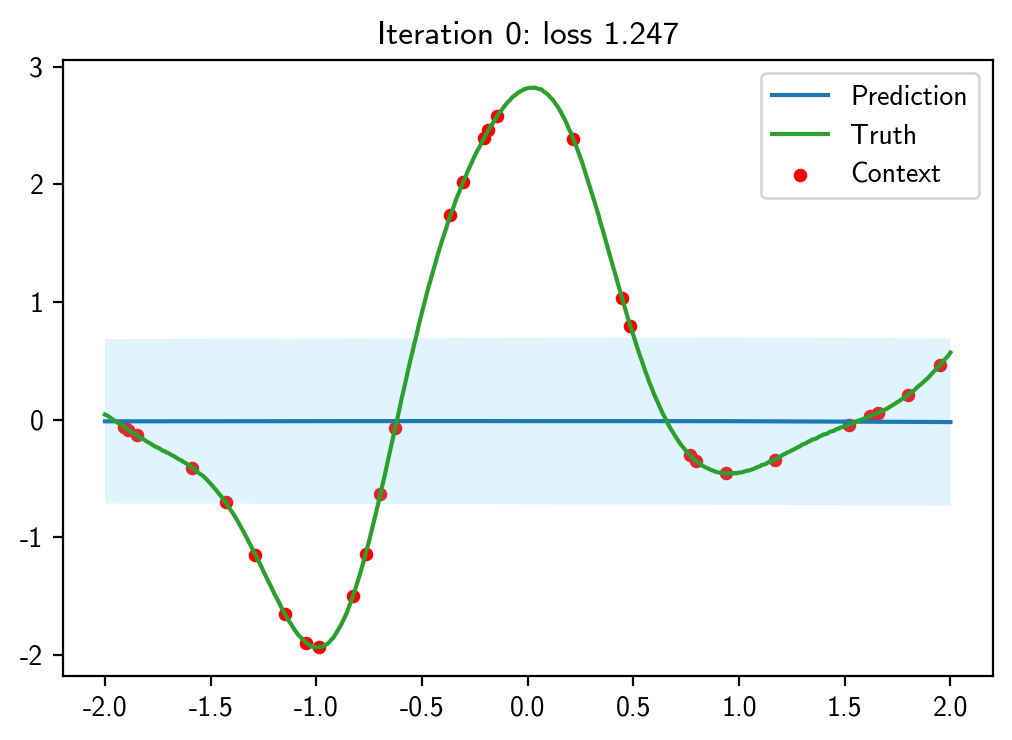

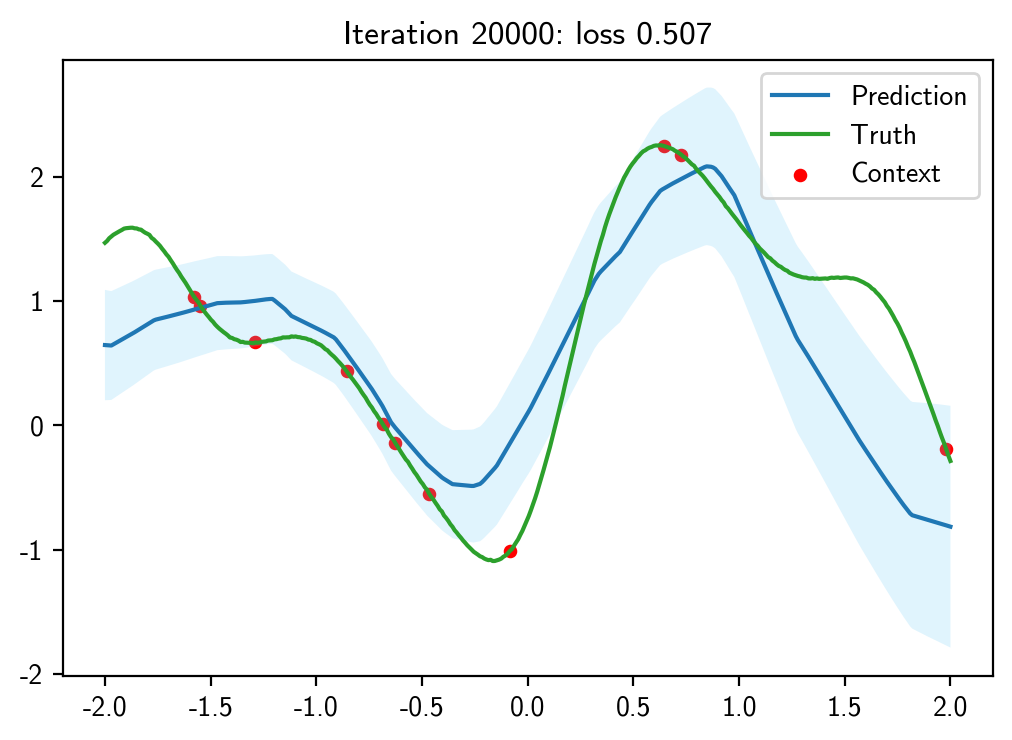

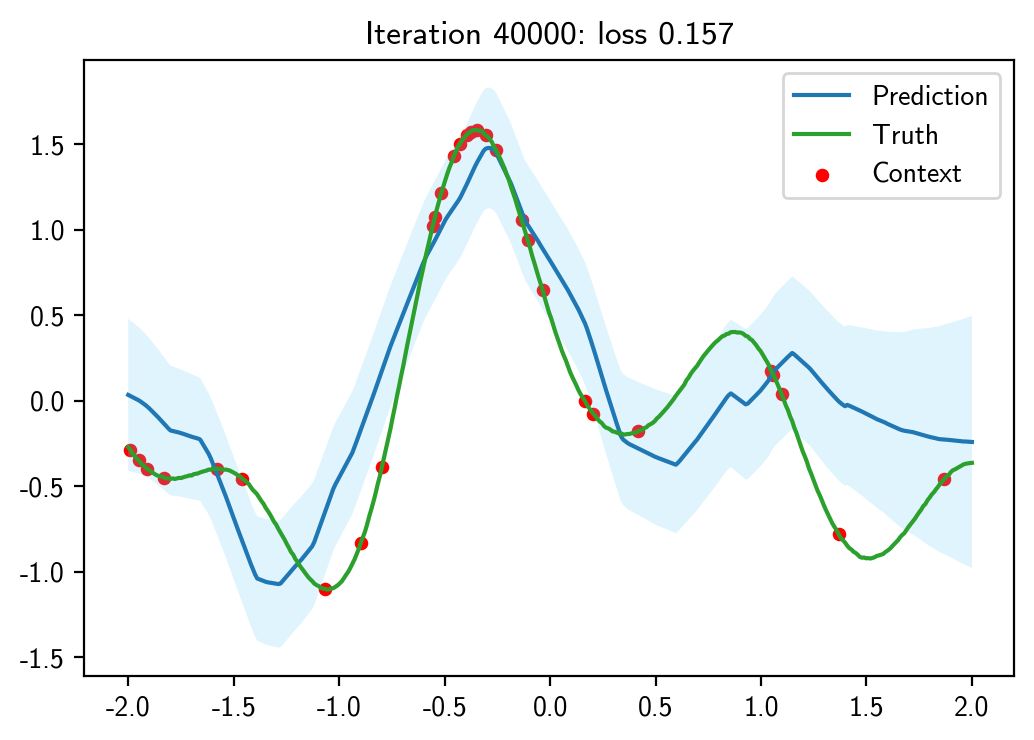

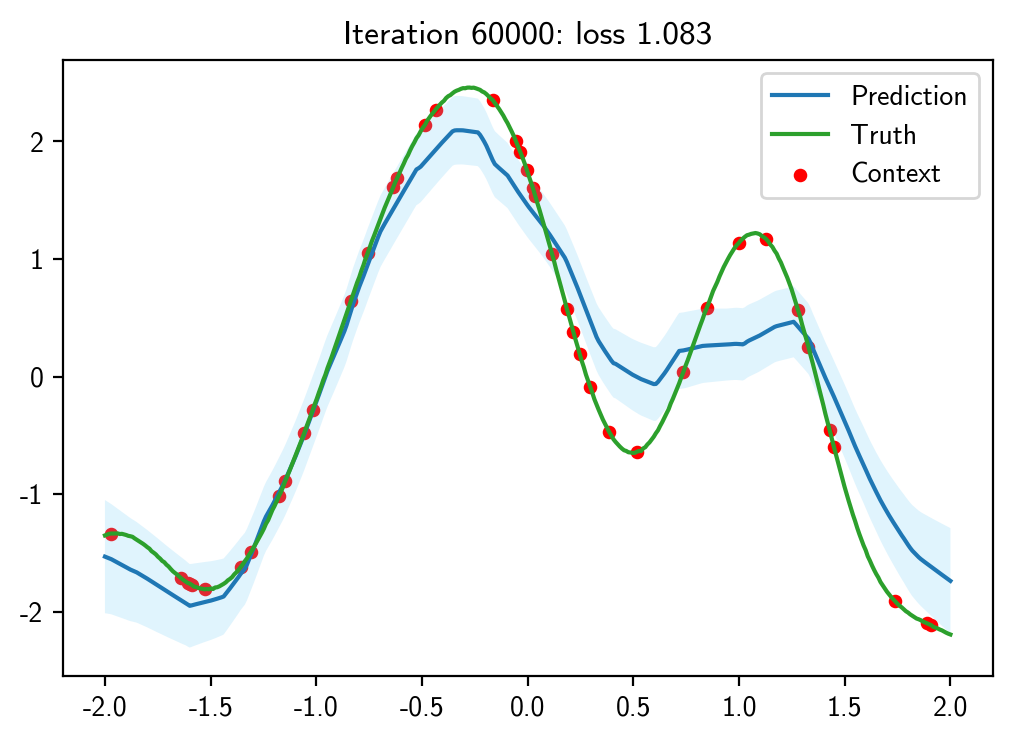

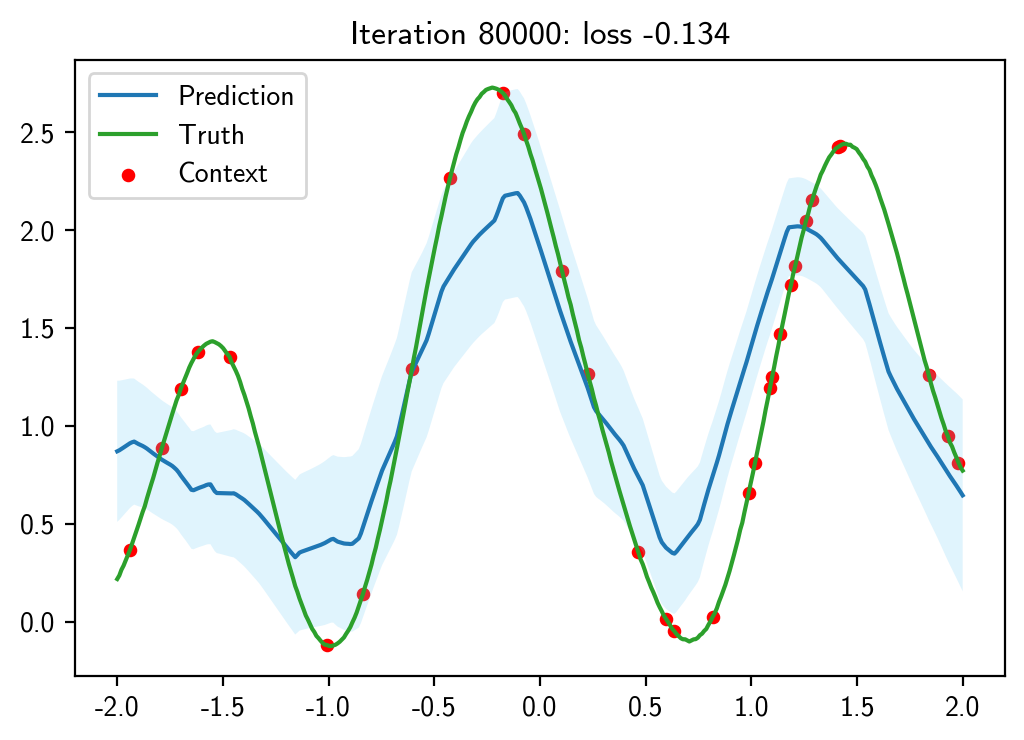

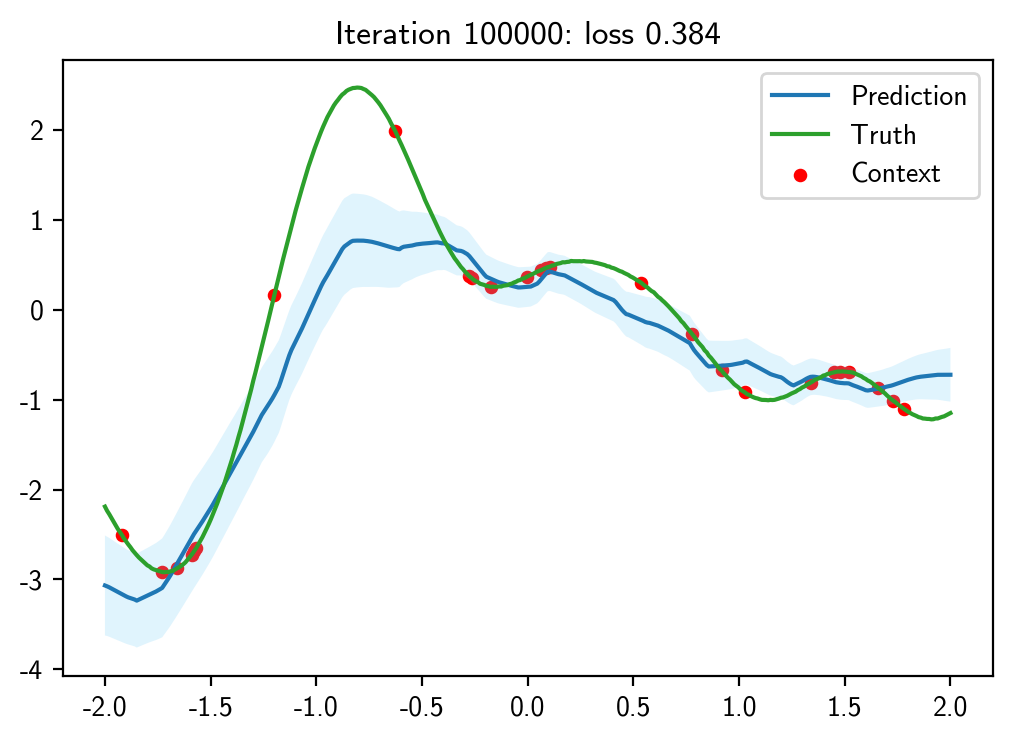

In [3]:
class ConditionalNeuralProcess(nn.Module):
    def __init__(self, hidden_size=128, x_dim=1, y_dim=1):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(x_dim + y_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size),)
        self.decoder = nn.Sequential(nn.Linear(hidden_size + x_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 2 * y_dim),)

    def forward(self, x_context, y_context, x_target):
        # x_context: [batch_size, num_context, x_dim]
        # y_context: [batch_size, num_context, y_dim]
        # x_target: [batch_size, num_points, x_dim]
        # y_target: [batch_size, num_points, y_dim]

        # Infer a global latent variable based on context input-output pairs
        latent = self.encoder(torch.cat([x_context, y_context], dim=-1)).mean(dim=1)

        # Concatenate the global latent variable to each target input
        latent = latent[:, None, :].repeat(1, x_target.size(1), 1)
        inputs = torch.cat([latent, x_target], dim=-1)

        # Output a factorized distribution for target outputs
        mean, std = self.decoder(inputs).chunk(2, dim=-1)
        std = 0.1 + 0.9 * F.softplus(std)
        return mean, std


model = ConditionalNeuralProcess().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
progress_bar = tqdm(range(int(1e5 + 1)), desc="Iteration", leave=False)

for it in progress_bar:
    x_context, y_context, x_target, y_target = generate_train_data()
    mean, std = model(x_context.cuda(), y_context.cuda(), x_target.cuda())
    log_prob = D.Normal(mean, std).log_prob(y_target.cuda())
    loss = -log_prob.mean()
    model.zero_grad()
    loss.backward()
    optimizer.step()
    progress_bar.set_postfix({"loss": "{:.3f}".format(loss.item())})

    if it % 20000 == 0:
        x_context, y_context, x_target, y_target = generate_test_data()
        mean, std = model(x_context.cuda(), y_context.cuda(), x_target.cuda())
        mean, std = mean.detach().cpu().numpy(), std.detach().cpu().numpy()

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.plot(x_target[0], mean[0], c="C0", label="Prediction")
        ax.scatter(x_context[0], y_context[0], c="r", s=15, label="Context")
        ax.plot(x_target[0], y_target[0], c="C2", label="Truth")
        ax.set_title("Iteration {}: loss {:.3f}".format(it, loss.item()))
        ax.fill_between(x_target[0, :, 0], mean[0, :, 0] - std[0, :, 0], mean[0, :, 0] + std[0, :, 0], alpha=0.2, facecolor="#65c9f7", interpolate=True)
        ax.legend()
        plt.show()

### Neural Processes

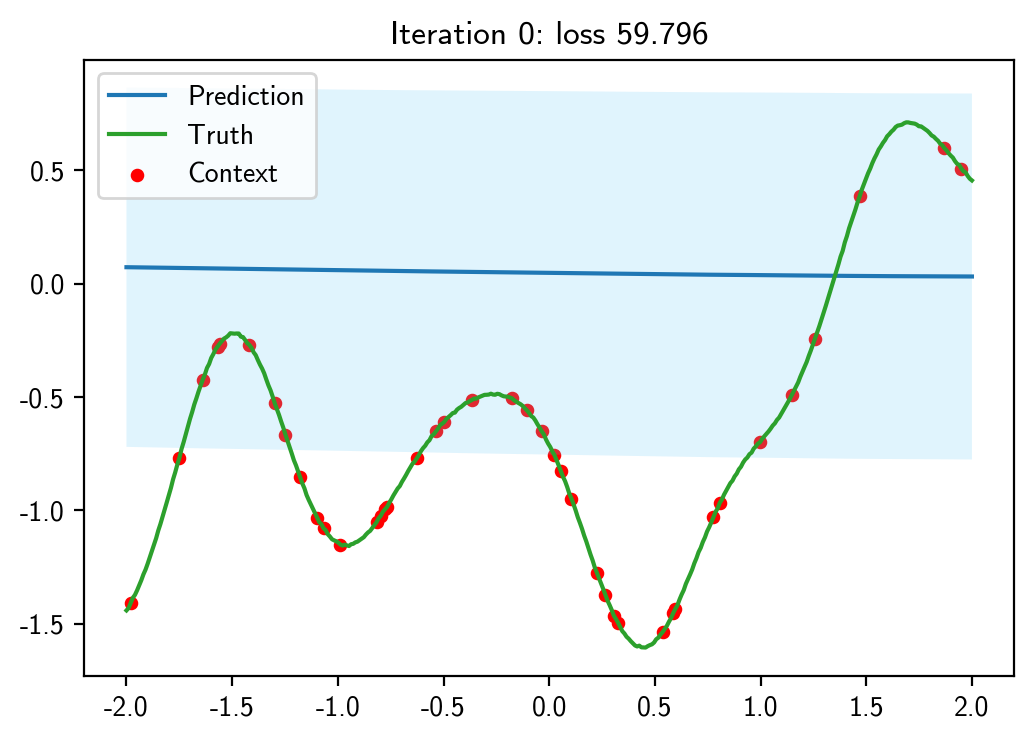

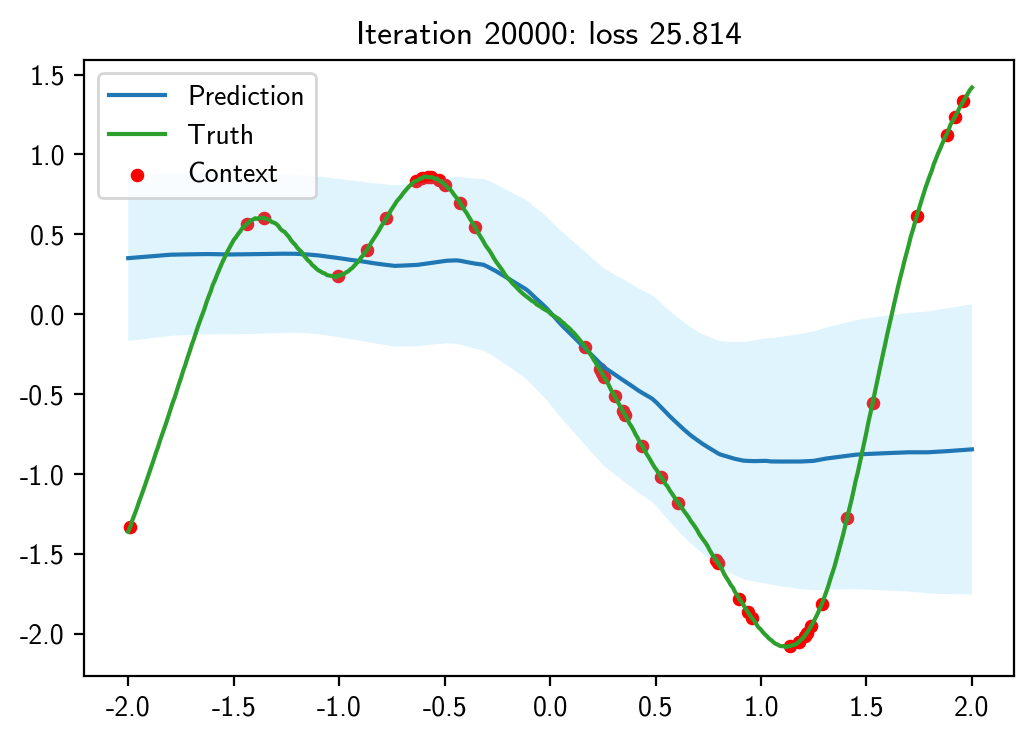

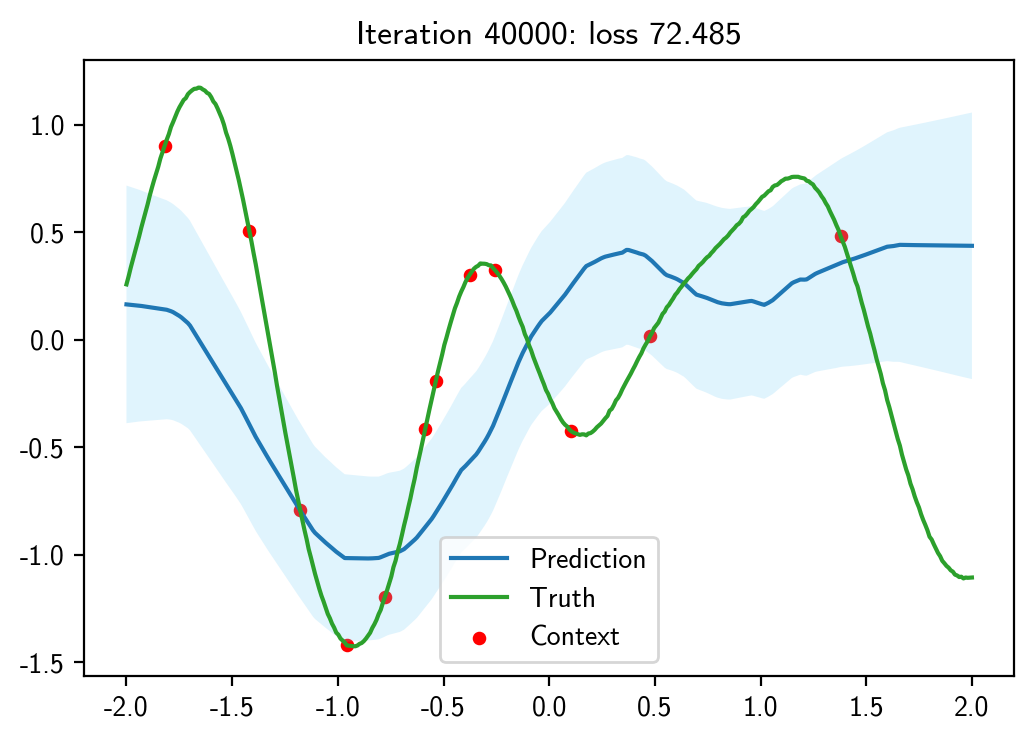

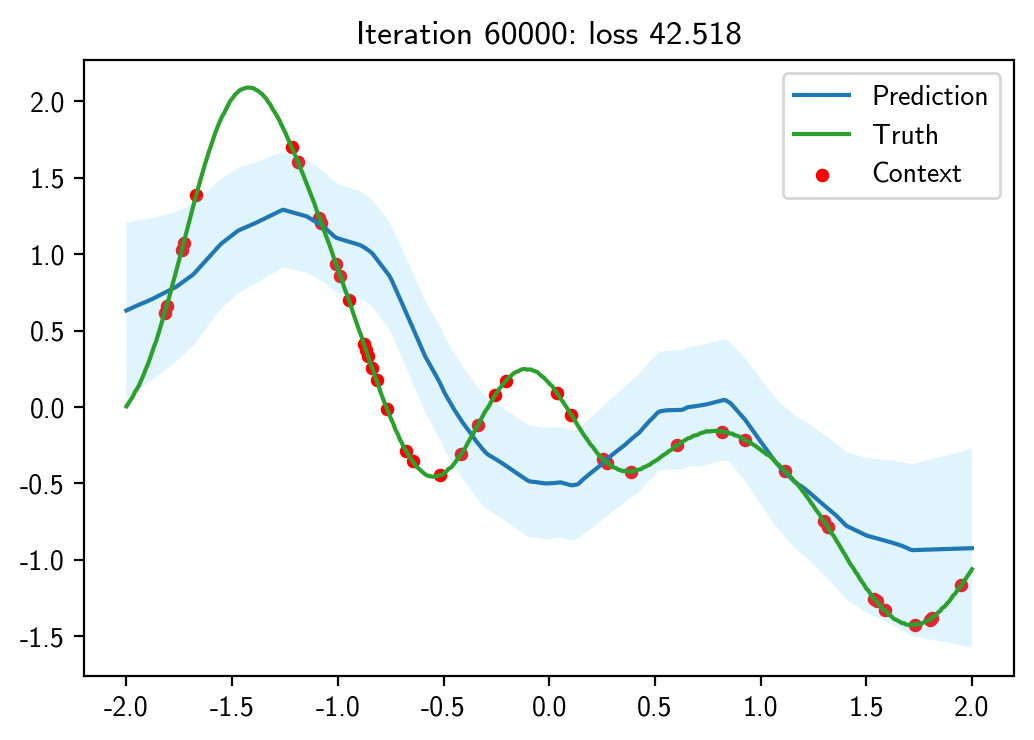

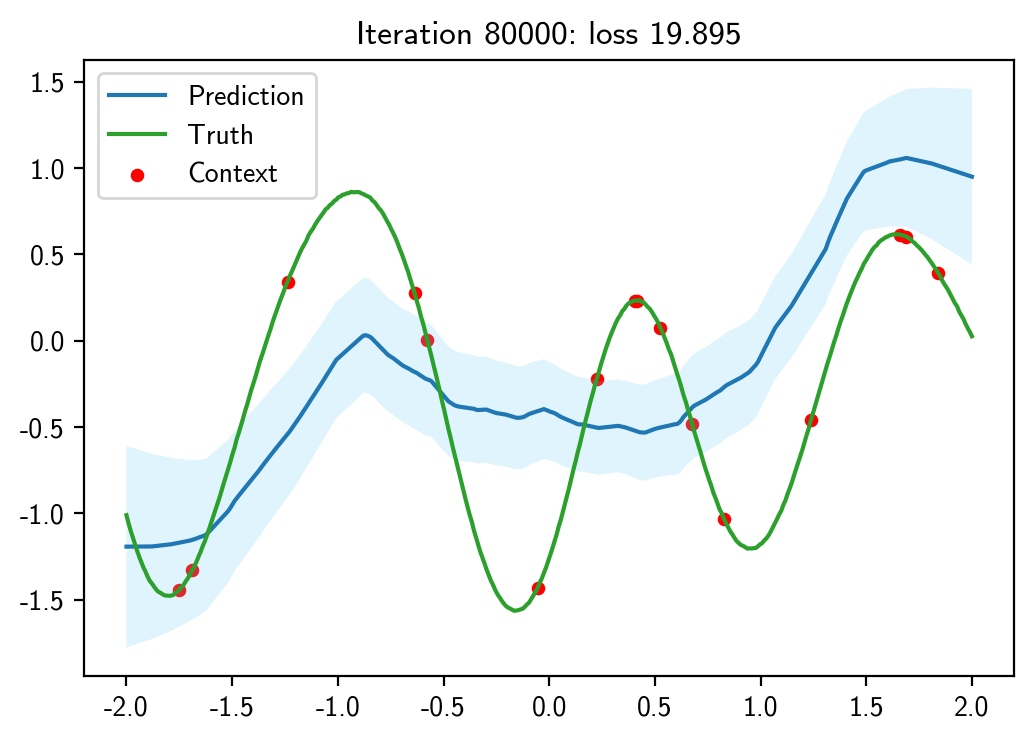

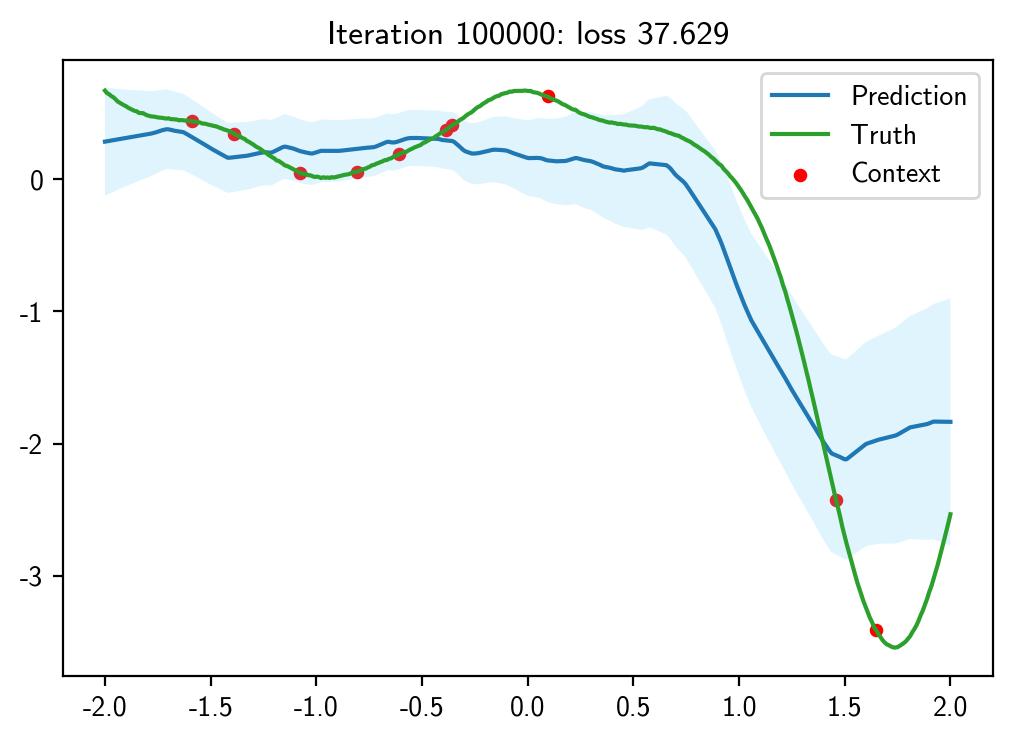

In [4]:
class LinearNormal(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 2 * out_features)

    def forward(self, inputs):
        mean, std = self.linear(inputs).chunk(2, dim=-1)
        std = 0.1 + 0.9 * F.softplus(std)
        return D.Normal(loc=mean, scale=std)


class NeuralProcess(nn.Module):
    def __init__(self, hidden_size=128, x_dim=1, y_dim=1):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(x_dim + y_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(),)
        self.mapping = LinearNormal(hidden_size, hidden_size)
        self.decoder = nn.Sequential(nn.Linear(hidden_size + x_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), LinearNormal(hidden_size, y_dim),)

    def forward(self, x_context, y_context, x_target, y_target=None):
        # x_context: [batch_size, num_context, x_dim]
        # y_context: [batch_size, num_context, y_dim]
        # x_target: [batch_size, num_points, x_dim]
        # y_target: [batch_size, num_points, y_dim]

        # Infer a global latent variable based on the context input-output pairs and
        # map the global latent variable to a factorized Gaussian distribution
        r_context = self.encoder(torch.cat([x_context, y_context], dim=-1)).mean(dim=1)
        z_prior = self.mapping(r_context)

        # After training, target input-output pairs are not available. We concatenate
        # a sample from z_prior to each target input to make predictions.
        if y_target is None:
            z_sample = z_prior.rsample()[:, None, :].repeat(1, x_target.size(1), 1)
            y_pred = self.decoder(torch.cat([z_sample, x_target], dim=-1))
            return y_pred

        # During training, infer another factorized Gaussian distribution using the
        # target input-output pairs, later to be matched with the previous distribution
        r_target = self.encoder(torch.cat([x_target, y_target], dim=-1)).mean(dim=1)
        z_posterior = self.mapping(r_target)

        # Concatenate a sample from z_posterior to each target input to make predictions
        z_sample = z_posterior.rsample()[:, None, :].repeat(1, x_target.size(1), 1)
        y_pred = self.decoder(torch.cat([z_sample, x_target], dim=-1))
        return z_prior, z_posterior, y_pred


model = NeuralProcess(hidden_size=128, x_dim=1, y_dim=1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
progress_bar = tqdm(range(int(1e5 + 1)), desc="Iteration", leave=False)

for it in progress_bar:
    x_context, y_context, x_target, y_target = generate_train_data()
    z_prior, z_posterior, y_pred = model(x_context.cuda(), y_context.cuda(), x_target.cuda(), y_target.cuda())

    log_prob = y_pred.log_prob(y_target.cuda()).mean(dim=0).sum()
    kl_loss = D.kl_divergence(z_posterior, z_prior).mean(dim=0).sum()
    loss = -log_prob + kl_loss

    model.zero_grad()
    loss.backward()
    optimizer.step()
    progress_bar.set_postfix({"loss": "{:.3f}".format(loss.item())})

    if it % 20000 == 0:
        x_context, y_context, x_target, y_target = generate_test_data()
        y_pred = model(x_context.cuda(), y_context.cuda(), x_target.cuda())
        mu, sigma = y_pred.loc.detach().cpu().numpy(), y_pred.scale.detach().cpu().numpy()

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.plot(x_target[0], mu[0], c="C0", label="Prediction")
        ax.scatter(x_context[0], y_context[0], c="r", s=15, label="Context")
        ax.plot(x_target[0], y_target[0], c="C2", label="Truth")
        ax.set_title("Iteration {}: loss {:.3f}".format(it, loss.item()))
        ax.fill_between(x_target[0, :, 0], mu[0, :, 0] - sigma[0, :, 0], mu[0, :, 0] + sigma[0, :, 0], alpha=0.2, facecolor="#65c9f7", interpolate=True)
        ax.legend()
        plt.show()

Epoch 00: loss 299.515, bce 299.290, kl 0.225


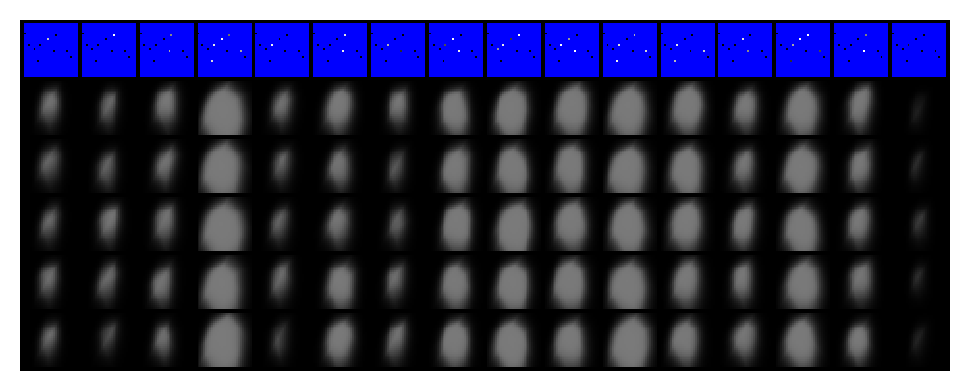

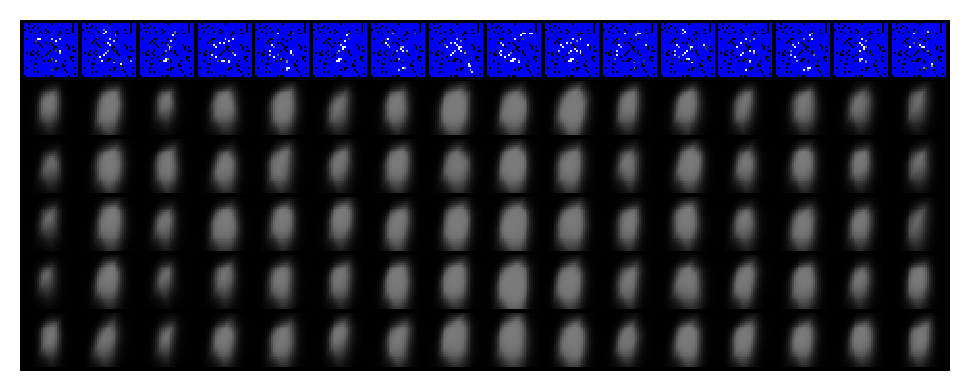

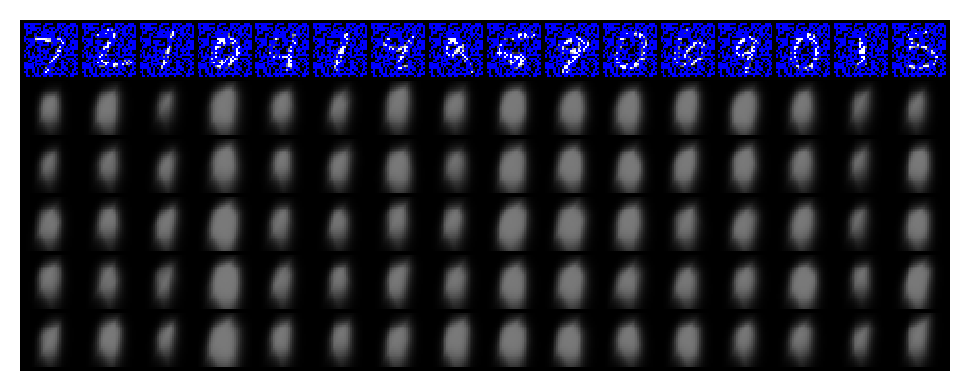

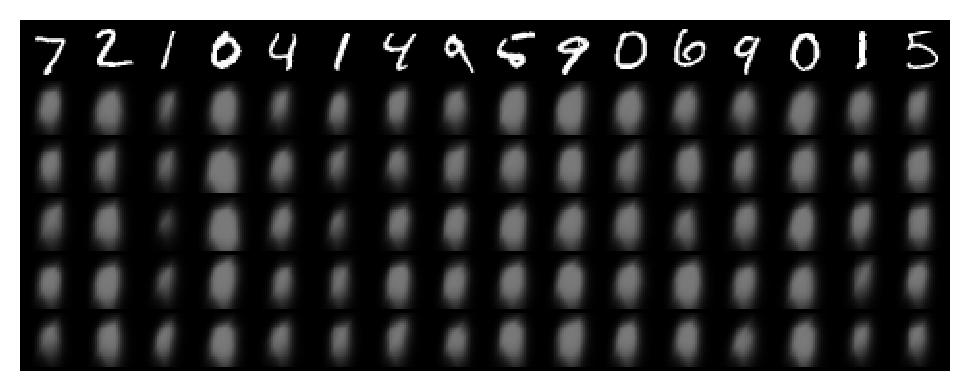

Epoch 01: loss 207.418, bce 204.768, kl 2.649
Epoch 02: loss 200.344, bce 198.898, kl 1.446
Epoch 03: loss 200.108, bce 198.070, kl 2.038
Epoch 04: loss 198.986, bce 197.351, kl 1.635
Epoch 05: loss 199.237, bce 196.958, kl 2.279
Epoch 06: loss 197.730, bce 196.455, kl 1.275
Epoch 07: loss 196.689, bce 195.416, kl 1.273
Epoch 08: loss 196.179, bce 195.010, kl 1.169
Epoch 09: loss 198.097, bce 195.856, kl 2.241
Epoch 10: loss 195.689, bce 194.562, kl 1.127
Epoch 11: loss 197.416, bce 195.043, kl 2.373
Epoch 12: loss 194.952, bce 194.107, kl 0.846
Epoch 13: loss 195.252, bce 193.774, kl 1.478
Epoch 14: loss 196.695, bce 193.483, kl 3.212
Epoch 15: loss 193.694, bce 191.804, kl 1.890
Epoch 16: loss 189.512, bce 187.738, kl 1.774
Epoch 17: loss 189.407, bce 186.654, kl 2.753
Epoch 18: loss 187.648, bce 185.393, kl 2.255
Epoch 19: loss 188.381, bce 185.053, kl 3.329
Epoch 20: loss 190.847, bce 187.735, kl 3.112


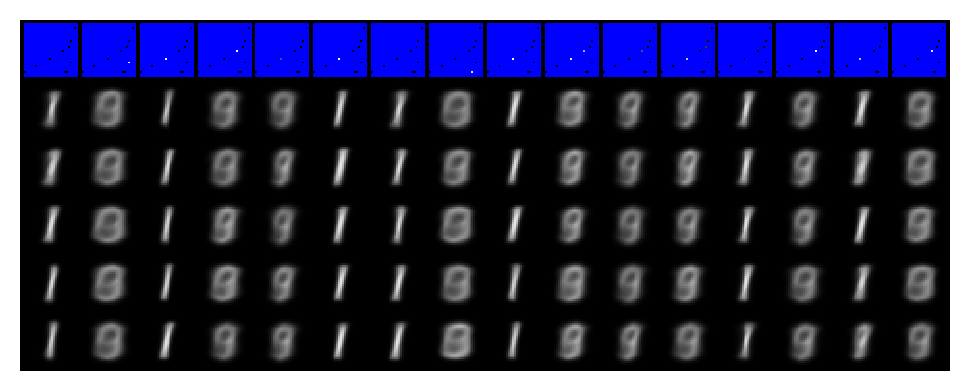

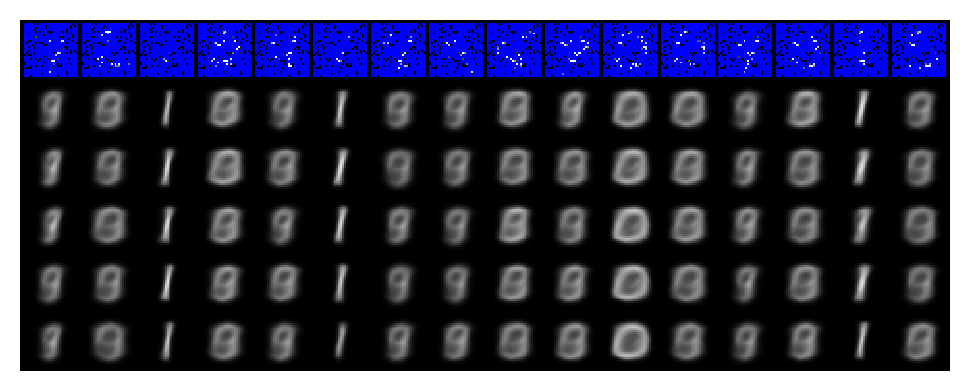

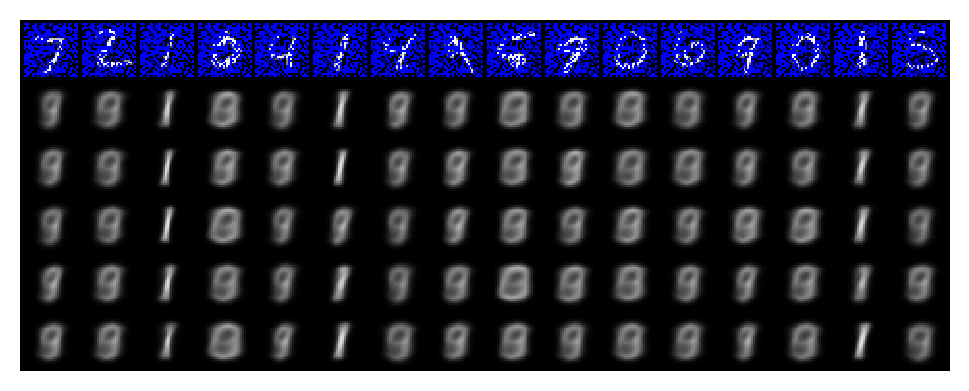

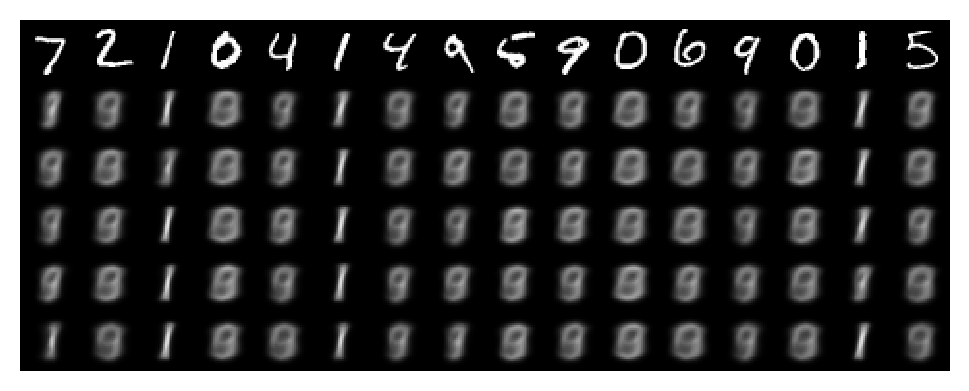

Epoch 21: loss 187.438, bce 185.162, kl 2.276
Epoch 22: loss 185.939, bce 182.637, kl 3.302
Epoch 23: loss 197.192, bce 193.063, kl 4.129
Epoch 24: loss 191.203, bce 188.098, kl 3.105
Epoch 25: loss 183.330, bce 180.787, kl 2.543
Epoch 26: loss 176.341, bce 173.857, kl 2.483
Epoch 27: loss 179.830, bce 174.682, kl 5.149
Epoch 28: loss 178.682, bce 171.728, kl 6.954
Epoch 29: loss 179.465, bce 175.522, kl 3.943
Epoch 30: loss 180.461, bce 174.038, kl 6.423
Epoch 31: loss 178.718, bce 174.741, kl 3.977
Epoch 32: loss 173.791, bce 169.813, kl 3.978
Epoch 33: loss 174.016, bce 169.264, kl 4.752
Epoch 34: loss 172.036, bce 168.176, kl 3.860
Epoch 35: loss 173.554, bce 168.258, kl 5.297
Epoch 36: loss 171.968, bce 166.662, kl 5.306
Epoch 37: loss 164.657, bce 159.051, kl 5.606
Epoch 38: loss 167.927, bce 160.570, kl 7.356
Epoch 39: loss 175.865, bce 165.678, kl 10.187
Epoch 40: loss 163.733, bce 158.314, kl 5.419


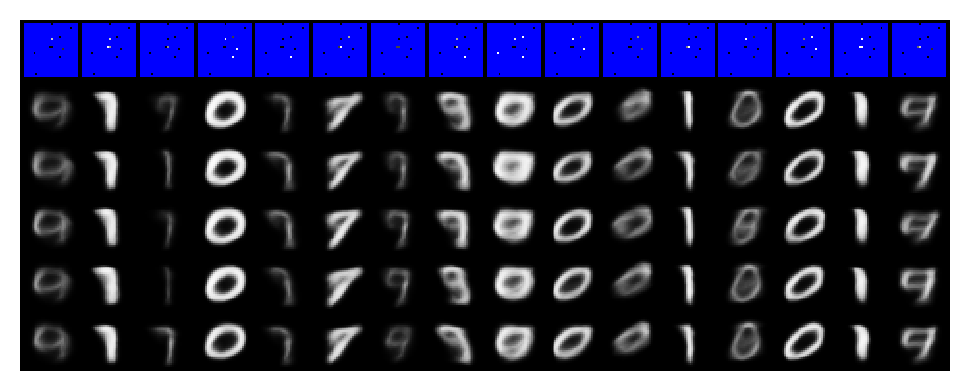

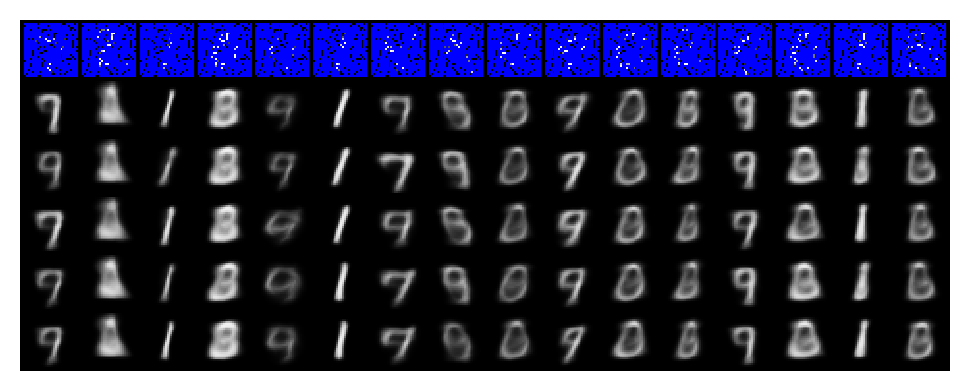

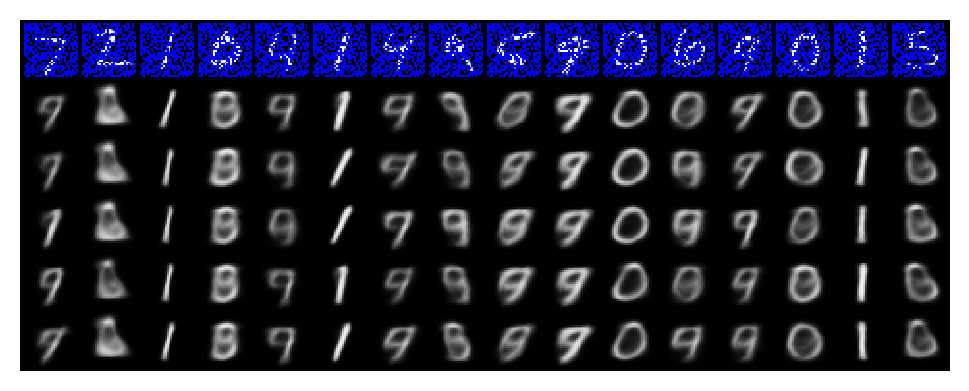

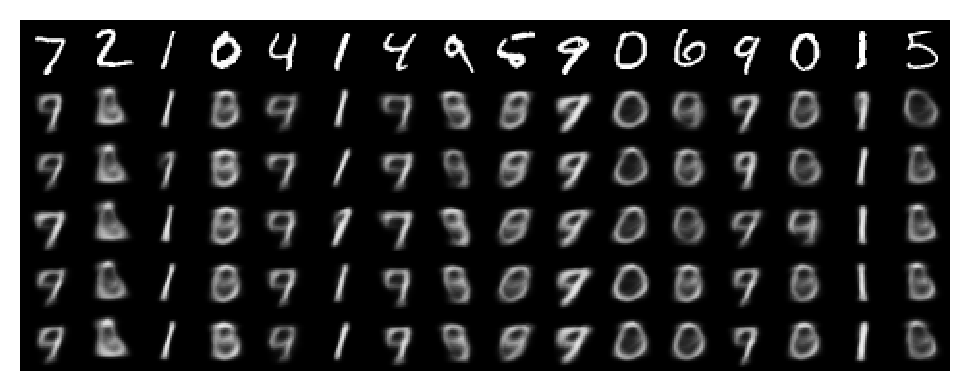

Epoch 41: loss 176.130, bce 164.112, kl 12.018
Epoch 42: loss 183.902, bce 163.725, kl 20.177
Epoch 43: loss 183.681, bce 173.218, kl 10.463
Epoch 44: loss 175.998, bce 171.094, kl 4.904
Epoch 45: loss 172.236, bce 167.746, kl 4.490
Epoch 46: loss 172.940, bce 166.434, kl 6.506
Epoch 47: loss 175.550, bce 166.586, kl 8.964
Epoch 48: loss 178.183, bce 170.088, kl 8.096
Epoch 49: loss 167.215, bce 161.864, kl 5.351
Epoch 50: loss 159.648, bce 154.422, kl 5.226
Epoch 51: loss 159.598, bce 150.162, kl 9.436
Epoch 52: loss 156.214, bce 147.472, kl 8.742
Epoch 53: loss 154.727, bce 145.362, kl 9.365
Epoch 54: loss 151.440, bce 143.217, kl 8.224
Epoch 55: loss 152.052, bce 143.940, kl 8.111
Epoch 56: loss 148.977, bce 139.772, kl 9.205
Epoch 57: loss 147.294, bce 138.838, kl 8.456
Epoch 58: loss 149.329, bce 140.055, kl 9.273
Epoch 59: loss 153.927, bce 139.271, kl 14.656
Epoch 60: loss 156.796, bce 147.805, kl 8.990


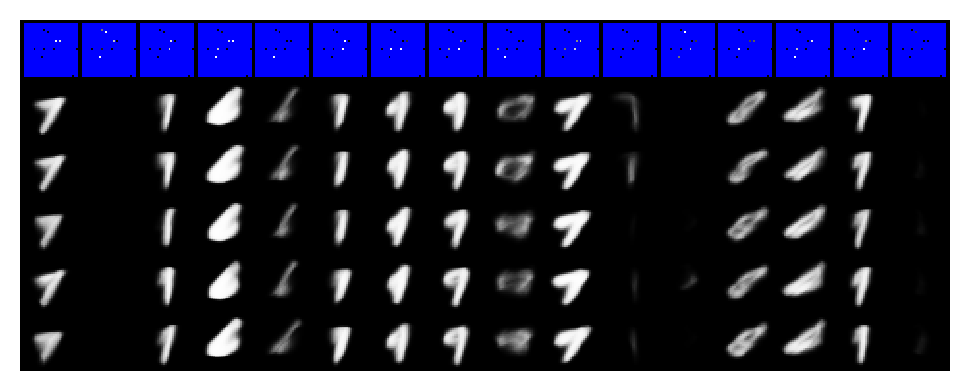

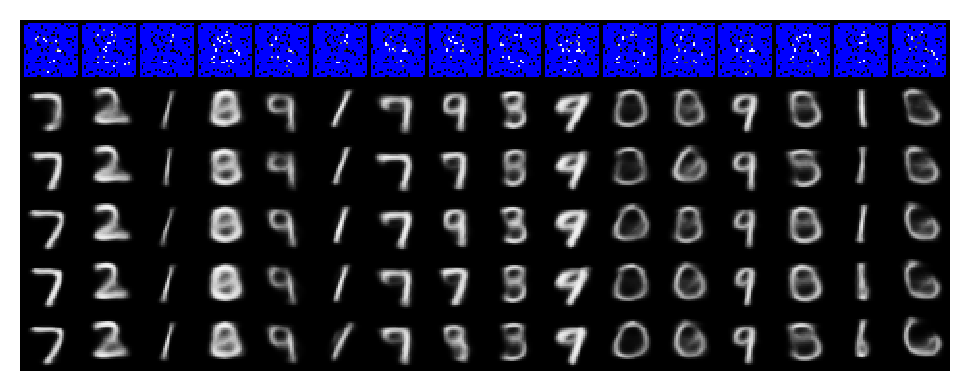

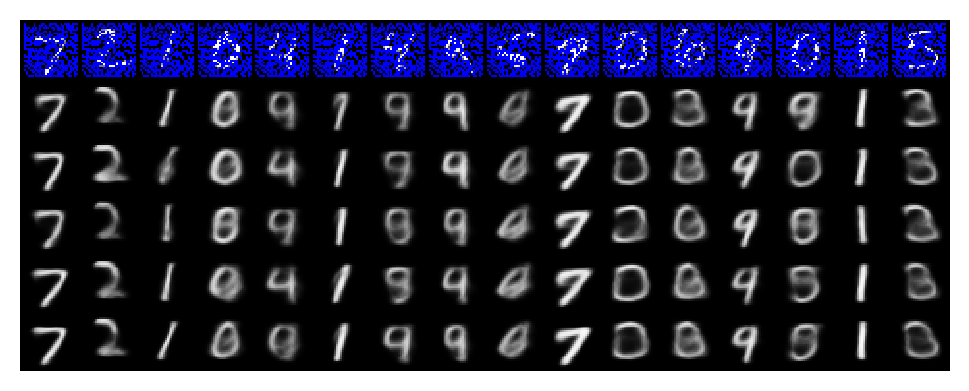

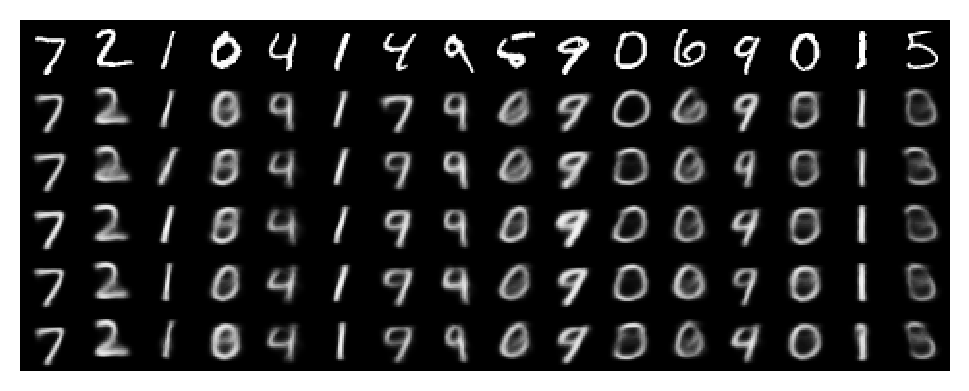

Epoch 61: loss 147.831, bce 138.650, kl 9.181
Epoch 62: loss 162.795, bce 149.617, kl 13.177
Epoch 63: loss 146.983, bce 138.344, kl 8.639
Epoch 64: loss 147.794, bce 137.821, kl 9.973
Epoch 65: loss 148.682, bce 138.143, kl 10.539
Epoch 66: loss 159.137, bce 139.381, kl 19.756
Epoch 67: loss 147.530, bce 140.397, kl 7.132
Epoch 68: loss 143.451, bce 136.096, kl 7.355
Epoch 69: loss 145.195, bce 135.434, kl 9.761
Epoch 70: loss 143.618, bce 133.502, kl 10.115
Epoch 71: loss 143.146, bce 133.210, kl 9.936
Epoch 72: loss 145.601, bce 134.547, kl 11.054
Epoch 73: loss 138.198, bce 130.631, kl 7.567
Epoch 74: loss 141.584, bce 130.659, kl 10.925
Epoch 75: loss 139.892, bce 130.293, kl 9.599
Epoch 76: loss 152.666, bce 137.487, kl 15.180
Epoch 77: loss 152.693, bce 138.607, kl 14.086
Epoch 78: loss 150.820, bce 136.457, kl 14.363
Epoch 79: loss 144.834, bce 133.187, kl 11.647
Epoch 80: loss 140.401, bce 131.534, kl 8.867


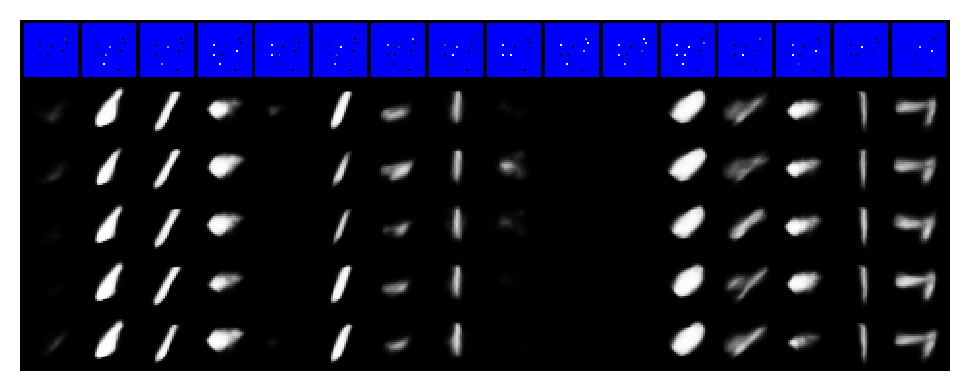

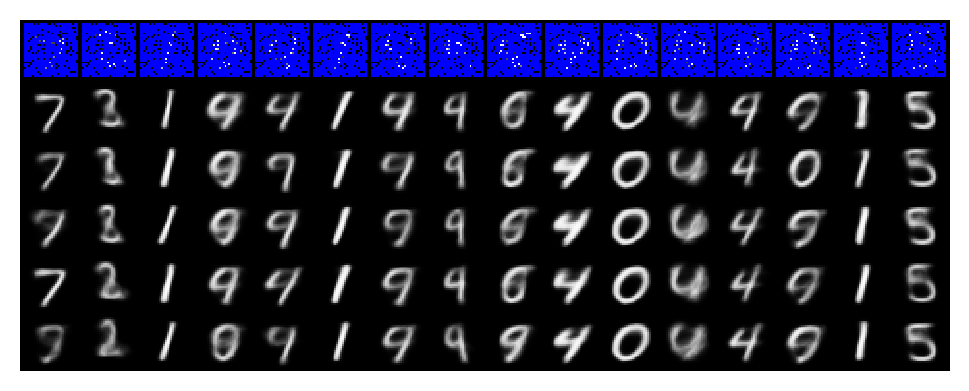

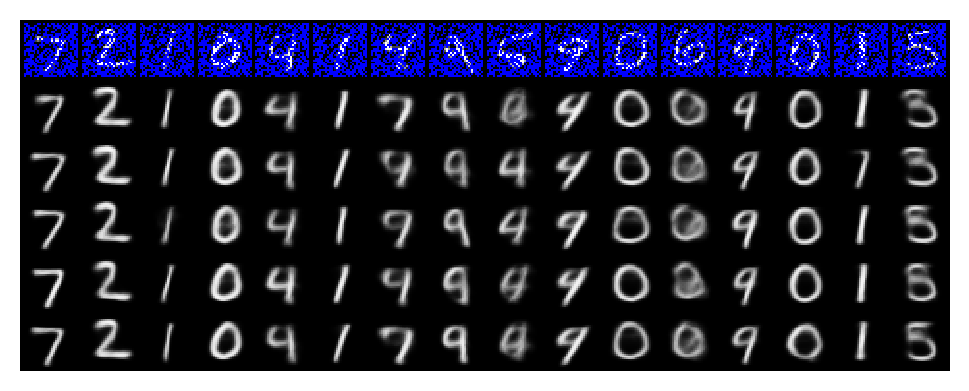

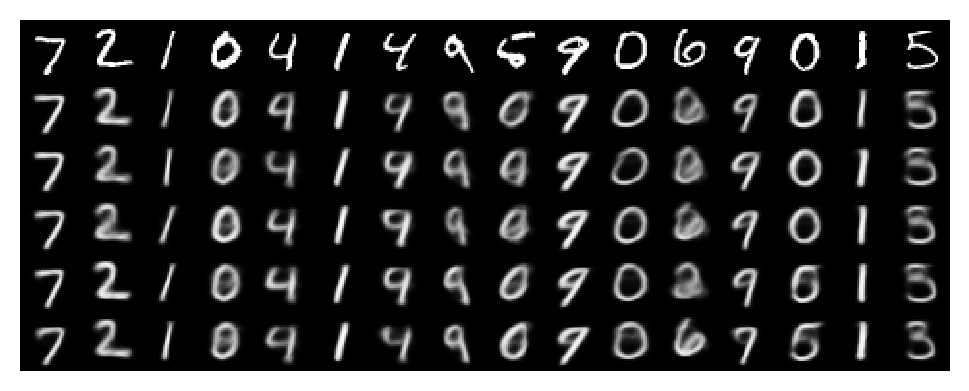

Epoch 81: loss 138.109, bce 129.177, kl 8.932
Epoch 82: loss 143.017, bce 130.079, kl 12.938
Epoch 83: loss 155.461, bce 138.870, kl 16.590
Epoch 84: loss 148.032, bce 137.017, kl 11.015
Epoch 85: loss 145.822, bce 133.558, kl 12.264
Epoch 86: loss 138.925, bce 129.800, kl 9.125
Epoch 87: loss 149.216, bce 134.684, kl 14.532
Epoch 88: loss 138.866, bce 128.799, kl 10.067
Epoch 89: loss 147.153, bce 132.362, kl 14.791
Epoch 90: loss 135.089, bce 126.701, kl 8.388
Epoch 91: loss 135.292, bce 125.431, kl 9.861
Epoch 92: loss 133.628, bce 124.429, kl 9.199
Epoch 93: loss 136.775, bce 124.969, kl 11.806
Epoch 94: loss 136.368, bce 124.293, kl 12.075
Epoch 95: loss 133.460, bce 123.690, kl 9.770
Epoch 96: loss 145.727, bce 129.133, kl 16.594
Epoch 97: loss 139.087, bce 126.882, kl 12.205
Epoch 98: loss 136.885, bce 125.035, kl 11.850
Epoch 99: loss 133.526, bce 123.406, kl 10.119


In [10]:
class LinearNormal(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 2 * out_features)

    def forward(self, inputs):
        mean, std = self.linear(inputs).chunk(2, dim=-1)
        std = 0.1 + 0.9 * F.softplus(std)
        return D.Normal(loc=mean, scale=std)


class NeuralProcess(nn.Module):
    def __init__(self, hidden_size=128, x_dim=1, y_dim=1, z_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(x_dim + y_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(),)
        self.mapping = LinearNormal(hidden_size, z_dim)
        self.decoder = nn.Sequential(nn.Linear(z_dim + x_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, y_dim), nn.Sigmoid(),)

    def forward(self, x_context, y_context, x_target, y_target=None):
        # x_context: [batch_size, num_context, x_dim]
        # y_context: [batch_size, num_context, y_dim]
        # x_target: [batch_size, num_points, x_dim]
        # y_target: [batch_size, num_points, y_dim]

        # Infer a global latent variable based on the context input-output pairs and
        # map the global latent variable to a factorized Gaussian distribution
        r_context = self.encoder(torch.cat([x_context, y_context], dim=-1)).mean(dim=1)
        z_prior = self.mapping(r_context)

        # After training, target input-output pairs are not available. We concatenate
        # a sample from z_prior to each target input to make predictions.
        if y_target is None:
            z_sample = z_prior.rsample()[:, None, :].repeat(1, x_target.size(1), 1)
            y_pred = self.decoder(torch.cat([z_sample, x_target], dim=-1))
            return y_pred

        # During training, infer another factorized Gaussian distribution using the
        # target input-output pairs, later to be matched with the previous distribution
        r_target = self.encoder(torch.cat([x_target, y_target], dim=-1)).mean(dim=1)
        z_posterior = self.mapping(r_target)

        # Concatenate a sample from z_posterior to each target input to make predictions
        z_sample = z_posterior.rsample()[:, None, :].repeat(1, x_target.size(1), 1)
        y_pred = self.decoder(torch.cat([z_sample, x_target], dim=-1))
        return z_prior, z_posterior, y_pred


torch.manual_seed(1)
random.seed(1)
train_loader = torch.utils.data.DataLoader(datasets.MNIST("/home/centos/data/mnist", train=True, transform=transforms.ToTensor()), batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST("/home/centos/data/mnist", train=False, transform=transforms.ToTensor()), batch_size=128, shuffle=False)
X, Y = torch.meshgrid(torch.linspace(0, 1, 28), torch.linspace(0, 1, 28))
x_grid = torch.cat((X.reshape(784, 1), Y.reshape(784, 1)), dim=-1).unsqueeze(dim=0).cuda()

model = NeuralProcess(hidden_size=128, x_dim=2, y_dim=1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(100):
    model.train()
    train_loss, train_bce, train_kl = 0.0, 0.0, 0.0
    for batch_idx, (y_target, _) in enumerate(train_loader):
        batch_size = y_target.size(0)
        x_target = x_grid.expand(batch_size, -1, -1)
        y_target = y_target.cuda().view(batch_size, -1, 1)

        context_idx = torch.tensor(random.sample(range(784), random.randint(1, 784))).cuda()
        x_context = torch.index_select(x_grid, dim=1, index=context_idx).expand(batch_size, -1, -1)
        y_context = torch.index_select(y_target, dim=1, index=context_idx)

        z_prior, z_posterior, y_pred = model(x_context, y_context, x_target, y_target)
        bce_loss = F.binary_cross_entropy(y_pred, y_target, reduction="sum")
        kl_loss = D.kl_divergence(z_posterior, z_prior).sum()
        loss = bce_loss + kl_loss
        model.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bce += bce_loss.item()
        train_kl += kl_loss.item()

    print("Epoch {:02d}: loss {:.3f}, bce {:.3f}, kl {:.3f}".format(epoch, train_loss / len(train_loader.dataset), train_bce / len(train_loader.dataset), train_kl / len(train_loader.dataset)))

    if epoch % 20 == 0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            y_target, _ = next(iter(test_loader))
            batch_size = y_target.size(0)
            x_target = x_grid.expand(batch_size, -1, -1)
            y_target = y_target.cuda().view(batch_size, -1, 1)

            num_examples = 16
            for num_context in [10, 100, 300, 784]:
                context_idx = torch.tensor(random.sample(range(784), num_context)).cuda()
                x_context = torch.index_select(x_grid, dim=1, index=context_idx).expand(batch_size, -1, -1)
                y_context = torch.index_select(y_target, dim=1, index=context_idx)

                recons = [model(x_context, y_context, x_target)[:num_examples] for _ in range(5)]
                recons = torch.cat(recons).view(-1, 1, 28, 28).expand(-1, 3, -1, -1)
                background = torch.tensor([0.0, 0.0, 1.0]).cuda()
                background = background.view(1, -1, 1).expand(num_examples, 3, 784).contiguous()
                context_pixels = y_target[:num_examples].view(num_examples, 1, -1)[:, :, context_idx]
                context_pixels = context_pixels.expand(num_examples, 3, -1)
                background[:, :, context_idx] = context_pixels
                comparison = torch.cat([background.view(-1, 3, 28, 28), recons])

                fig, ax = plt.subplots(1, 1)
                ax.imshow(torchvision.utils.make_grid(comparison.cpu(), nrow=num_examples).permute(1, 2, 0))
                ax.axis("off")
                plt.show();

### Attentive Neural Process

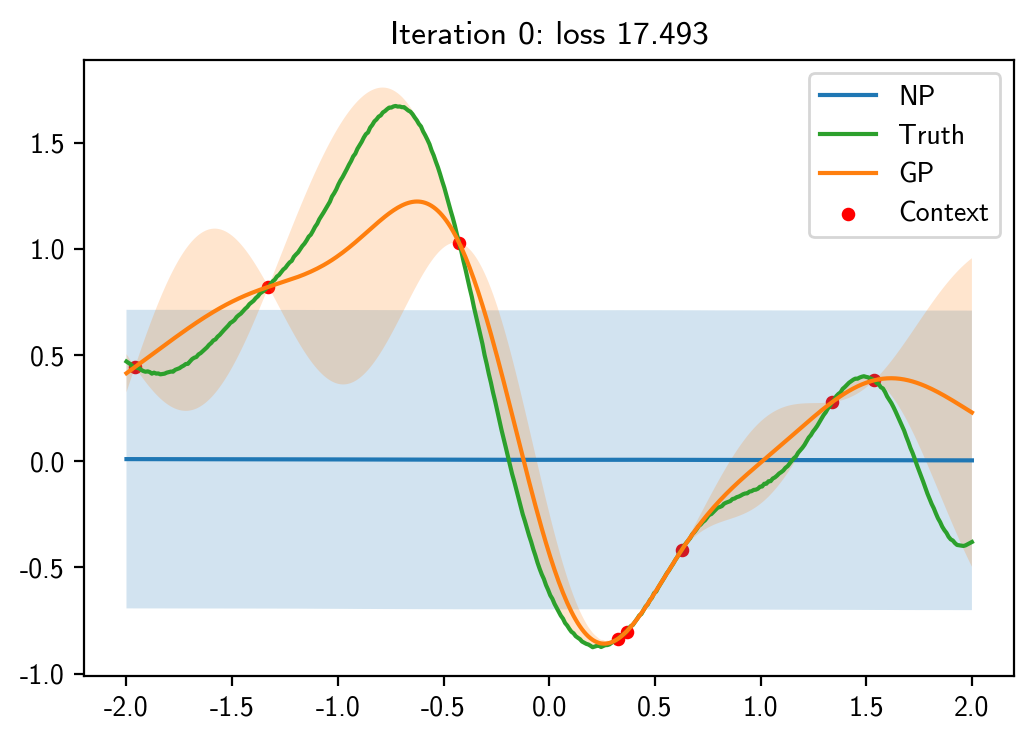

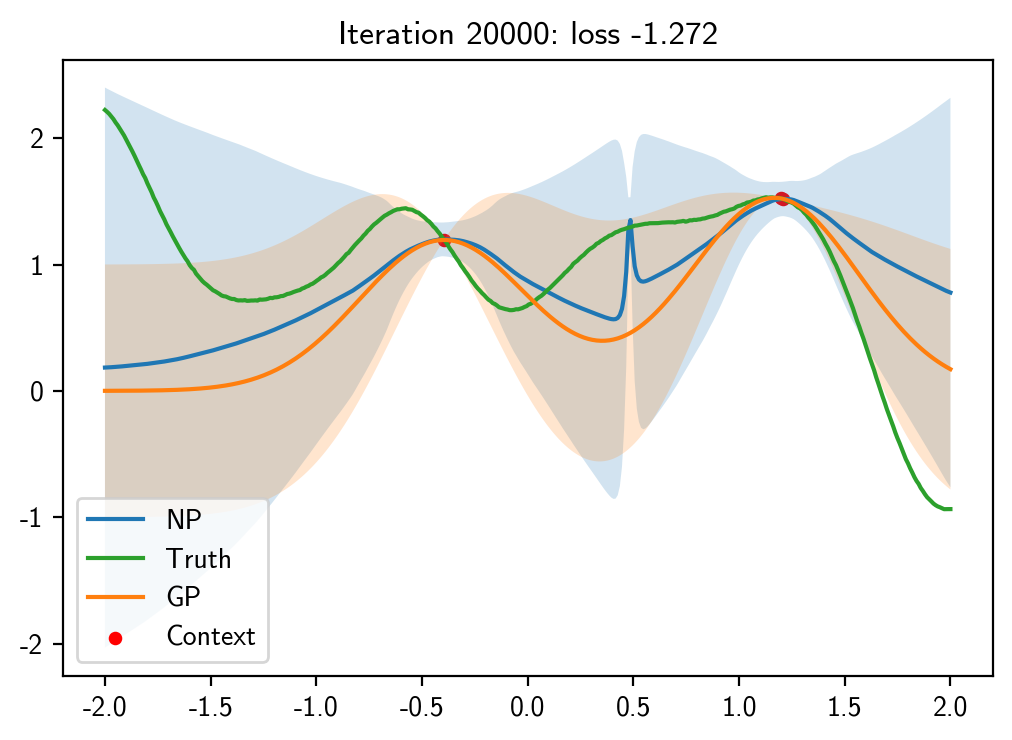

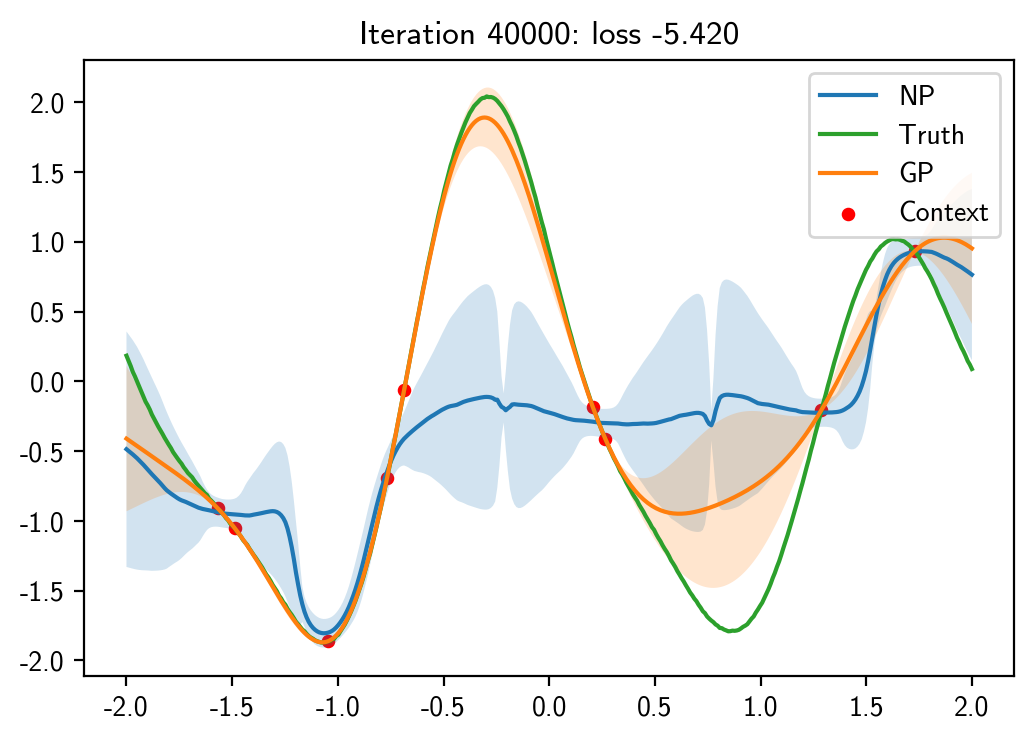

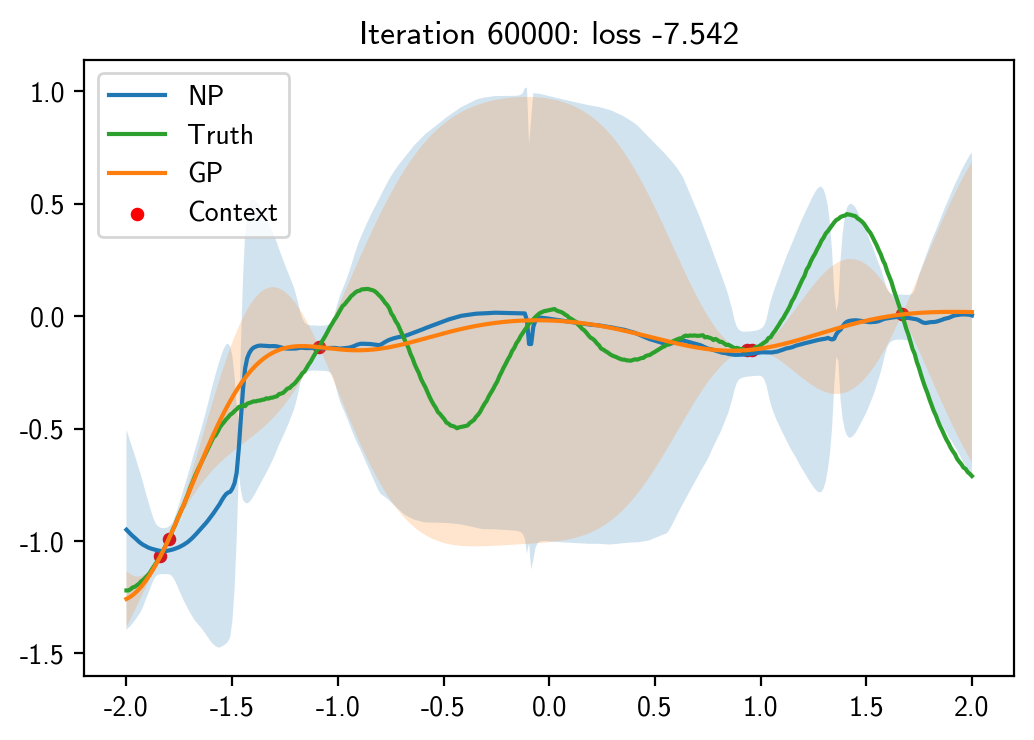

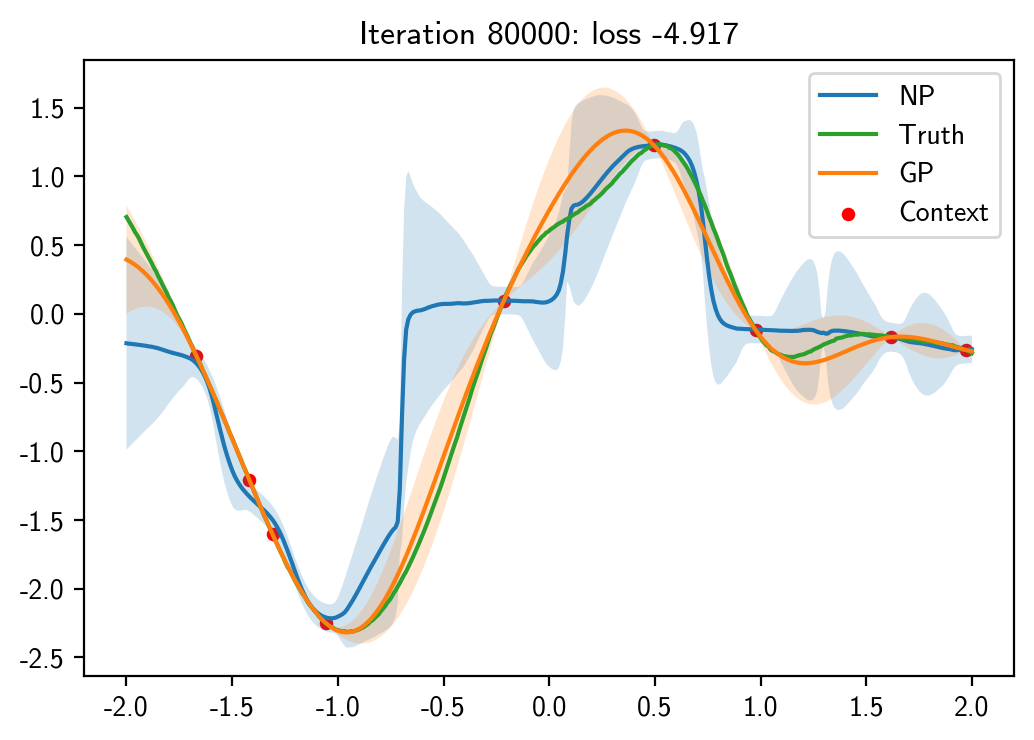

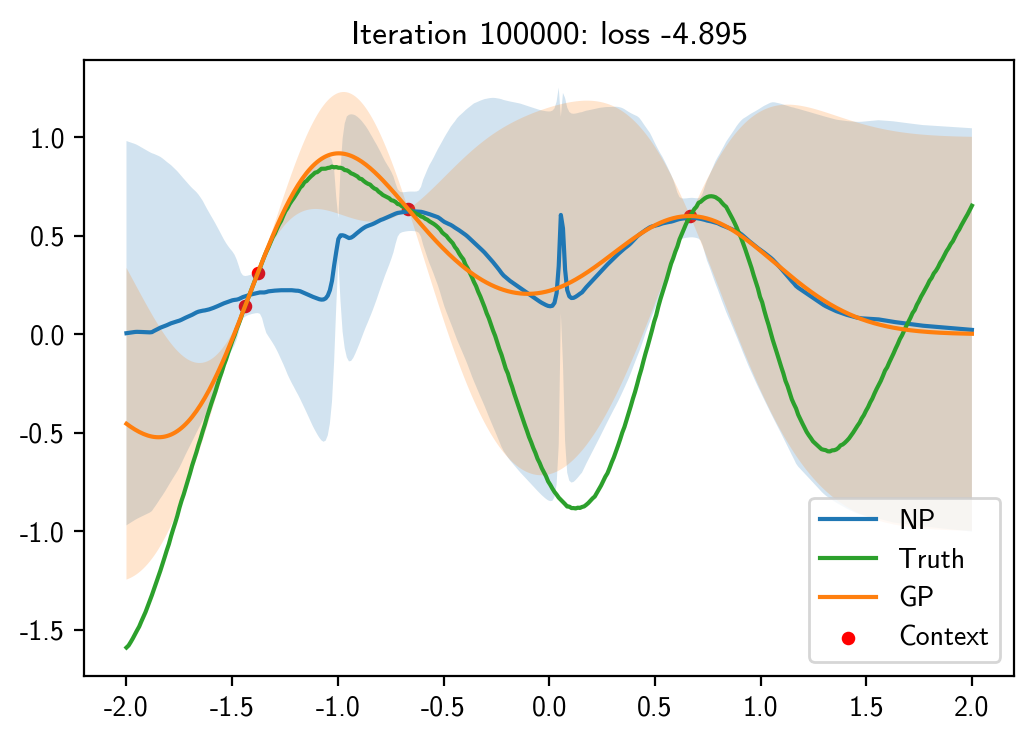

In [186]:
class UniformAttention(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, query, key, value):
        return value.mean(dim=1, keepdims=True).repeat(1, query.size(1), 1)
    

class LaplaceAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, scale=1., normalize=True):
        super().__init__()
        self.scale = scale
        self.normalize = normalize
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        
    def forward(self, query, key, value):
        query, key = self.net(query), self.net(key)
        weights = -((query[:, :, None, :] - key[:, None, :, :]).abs() / self.scale).sum(dim=-1)
        weights = F.softmax(weights, dim=-1) if self.normalize else 1 + F.tanh(weights)
        return torch.bmm(weights, value)
    
    
class DotProductAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, normalize=True):
        super().__init__()
        self.normalize = normalize
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        
    def forward(self, query, key, value):
        query, key = self.net(query), self.net(key)
        weights = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        weights = F.softmax(weights, dim=-1) if self.normalize else F.sigmoid(weights)
        return torch.bmm(weights, value)
    

class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads
        
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.query_proj = nn.Linear(input_dim, output_dim, bias=False)
        self.key_proj = nn.Linear(input_dim, output_dim, bias=False)
        self.value_proj = nn.Linear(output_dim, output_dim, bias=False)
        self.output_proj = nn.Linear(output_dim, output_dim, bias=False)
        
        for layer in [self.query_proj, self.key_proj, self.value_proj, self.output_proj]:
            layer.weight.data.normal_(std=layer.in_features ** -0.5)
        
    def forward(self, query, key, value):
        batch_size, query_len, _ = query.size()
        query, key = self.net(query), self.net(key)
            
        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3).contiguous().view(batch_size * self.num_heads, -1, self.head_dim)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3).contiguous().view(batch_size * self.num_heads, -1, self.head_dim)
        weights = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        weights = F.softmax(weights, dim=-1)
        
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3).contiguous().view(batch_size * self.num_heads, -1, self.head_dim)
        output = torch.bmm(weights, value).view(batch_size, self.num_heads, query_len, self.head_dim).permute(0, 2, 1, 3).contiguous().view(batch_size, query_len, self.num_heads * self.head_dim)
        return self.output_proj(output)
    
    
class LinearNormal(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 2 * out_features)

    def forward(self, inputs):
        mean, std = self.linear(inputs).chunk(2, dim=-1)
        std = 0.1 + 0.9 * F.softplus(std)
        return D.Normal(loc=mean, scale=std)

    
class AttentiveNeuralProcess(nn.Module):
    def __init__(self, hidden_dim=128, x_dim=1, y_dim=1, z_dim=128):
        super().__init__()
        self.attention_encoder = nn.Sequential(nn.Linear(x_dim + y_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim),)
        self.attention_mapping = DotProductAttention(x_dim, hidden_dim)
        self.latent_encoder = nn.Sequential(nn.Linear(x_dim + y_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim),)
        self.latent_mapping = LinearNormal(hidden_dim, z_dim)
        self.decoder = nn.Sequential(nn.Linear(2 * hidden_dim + x_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), LinearNormal(hidden_dim, y_dim),)

    def forward(self, x_context, y_context, x_target, y_target=None):
        # x_context: [batch_size, num_context, x_dim]
        # y_context: [batch_size, num_context, y_dim]
        # x_target: [batch_size, num_points, x_dim]
        # y_target: [batch_size, num_points, y_dim]
        
        # Compute attentive representations for target outputs
        h_context = self.attention_encoder(torch.cat([x_context, y_context], dim=-1))
        h_target = self.attention_mapping(x_target, x_context, h_context)
        
        # Infer a global latent variable based on the context input-output pairs and
        # map the global latent variable to a factorized Gaussian distribution
        r_context = self.latent_encoder(torch.cat([x_context, y_context], dim=-1)).mean(dim=1)
        z_prior = self.latent_mapping(r_context)
        
        # After training, target input-output pairs are not available. We concatenate the deterministic
        # attention representation and a sample from z_prior to each target input to make predictions.
        if y_target is None:
            z_sample = z_prior.rsample()[:, None, :].repeat(1, x_target.size(1), 1)
            y_pred = self.decoder(torch.cat([h_target, z_sample, x_target], dim=-1))
            return y_pred

        # During training, infer another factorized Gaussian distribution using the
        # target input-output pairs, later to be matched with the previous distribution
        r_target = self.latent_encoder(torch.cat([x_target, y_target], dim=-1)).mean(dim=1)
        z_posterior = self.latent_mapping(r_target)

        # Concatenate a sample from z_posterior to each target input to make predictions
        z_sample = z_posterior.rsample()[:, None, :].repeat(1, x_target.size(1), 1)
        y_pred = self.decoder(torch.cat([h_target, z_sample, x_target], dim=-1))
        return z_prior, z_posterior, y_pred
    

model = AttentiveNeuralProcess().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
progress_bar = tqdm(range(int(1e5 + 1)), desc="Iteration", leave=False)

for it in progress_bar:
    x_context, y_context, x_target, y_target = generate_train_data(max_num_context=10)
    z_prior, z_posterior, y_pred = model(x_context.cuda(), y_context.cuda(), x_target.cuda(), y_target.cuda())

    log_prob = y_pred.log_prob(y_target.cuda()).mean(dim=0).sum()
    kl_loss = D.kl_divergence(z_posterior, z_prior).mean(dim=0).sum()
    loss = -log_prob + kl_loss

    model.zero_grad()
    loss.backward()
    optimizer.step()
    progress_bar.set_postfix({"loss": "{:.3f}".format(loss.item())})

    if it % 20000 == 0:
        x_context, y_context, x_target, y_target = generate_test_data(max_num_context=10)
        y_pred = model(x_context.cuda(), y_context.cuda(), x_target.cuda())
        mu, sigma = y_pred.loc.detach().cpu().numpy(), y_pred.scale.detach().cpu().numpy()

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.plot(x_target[0], mu[0], c="C0", label="NP")
        ax.scatter(x_context[0], y_context[0], c="r", s=15, label="Context")
        ax.plot(x_target[0], y_target[0], c="C2", label="Truth")
        ax.set_title("Iteration {}: loss {:.3f}".format(it, loss.item()))
        ax.fill_between(x_target[0, :, 0], mu[0, :, 0] - sigma[0, :, 0], mu[0, :, 0] + sigma[0, :, 0], alpha=0.2, facecolor='C0', interpolate=True)

        mu, std = posterior_predictive(x_target, x_context, y_context)
        ax.plot(x_target[0], mu[0], c='C1', label="GP")
        ax.fill_between(x_target[0].squeeze(), mu[0].squeeze() - std[0], mu[0].squeeze() + std[0], facecolor='C1', alpha=0.2)
        ax.legend()
        plt.show()

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())